<a href="https://colab.research.google.com/github/JoshStrong/2LayerMLP/blob/master/2LayerMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Julia on Colaboratory ##

[Colaboratory](https://colab.research.google.com) does not provide native support for the [Julia programming language](https://julialang.org). However, since Colaboratory gives you root access to the machine that runs your notebook (the *“runtime”* in Colaboratory terminology), we can install Julia support by uploading a specially crafted Julia notebook  – *this* notebook. We then install Julia and [IJulia](https://github.com/JuliaLang/IJulia.jl) ([Jupyter](https://jupyter.org)/Colaboratory notebook support) and reload the notebook so that Colaboratory detects and initiates what we installed.

In brief:

1. **Run the cell below**
2. **Reload the page**
3. **Edit the notebook name and start hacking Julia code below**

**If your runtime resets**, either manually or if left idle for some time, **repeat steps 1 and 2**.

### Acknowledgements ###

This hack by Pontus Stenetorp is an adaptation of [James Bradbury’s original Colaboratory Julia hack](https://discourse.julialang.org/t/julia-on-google-colab-free-gpu-accelerated-shareable-notebooks/15319/27), that broke some time in September 2019 as Colaboratory increased their level of notebook runtime isolation. There also appears to be CUDA compilation support installed by default for each notebook runtime type in October 2019, which shaves off a good 15 minutes or so from the original hack’s installation time.

In [ ]:
# Installation cell
%%shell
if ! command -v julia 2>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.0/julia-1.0.5-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'

In [ ]:
# Required packages
using Pkg

pkg"add FiniteDifferences; precompile;" # for gradient evaluations
using FiniteDifferences

pkg"add NamedArrays; precompile;"
using NamedArrays

pkg"add NPZ; precompile;"
using NPZ

pkg"add MLDatasets; precompile;"
using MLDatasets

pkg"add Plots; precompile;"
using Plots

using LinearAlgebra
using Random

**Data**

In [ ]:
# Load data & reshape

#train: 12,000 obs. with 28*28=784 features each
trainxs = npzread("/content/data/fashion-train-imgs.npz")
trainys = npzread("/content/data/fashion-train-labels.npz")
devxs   = npzread("/content/data/fashion-dev-imgs.npz")
devys   = npzread("/content/data/fashion-dev-labels.npz")
testxs  = npzread("/content/data/fashion-test-imgs.npz")
testys  = npzread("/content/data/fashion-test-labels.npz");

n = size(trainxs)[1]  # number of training examples
d = size(trainxs)[2];  # number of features

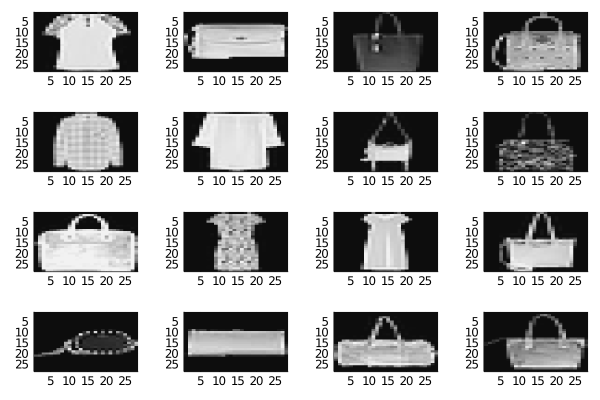

In [ ]:
# Plotting random training samples.
plt = plot(layout=(4, 4))
for i in 1:4^2
    heatmap!(plt, trainxs[:, :, rand(1:size(trainxs, 3))]',
        subplot=i, yflip=true, color=:grays, colorbar = false)
end
plt

In [ ]:
# Reshape the datasets into 1D vectors
trainxs = reshape(trainxs, (:, 12000))'
devxs = reshape(devxs, (:, 1000))'
testxs = reshape(testxs, (:, 1000))';

#### Calculations for partial derivatives of the error w.r.t. $W_2$, $W_1$, $b_2$ & $b_1$ :

For a 2 layer MLP with $k=2$, we have:

\begin{align}
\text{Error} = -ylog(h_{2}) - (1 - y)log(1-h_{2}) \\
h_1(x) = \sigma(W_1 x + b_1)\\
h_2(x) = \sigma(W_2 h_1(x) + b_2)
\end{align}

To compute partial derivative of error w.r.t. $W_2$:

\begin{align}
\frac{\partial{E}}{\partial{W_2}} = \frac{\partial{E}}{\partial{h_2}} \frac{\partial{h_2}}{\partial{W_2}}
\end{align}

We have:

\begin{align}
\frac{\partial{E}}{\partial{h_2}} = \frac{\partial{(-ylog(h_{2}) - (1 - y)log(1-h_{2}))}}{\partial{h_2}} = \frac{-y + h_2}{h_{2}(1-h_{2})}
\end{align}

and (using $\sigma(x)'=\sigma(x)(1-\sigma(x))$ & setting $a_2 = W_2 h_{1} + b_2)$,

\begin{align}
\frac{\partial{h_2}}{\partial{W_2}} = \frac{\partial{(\sigma(W_2 h_1(x) + b_2))}}{\partial{W_2}} = \frac{\partial{h_2}}{\partial{a_2}}\frac{\partial{a_2}}{\partial{W_2}} = h_2(1-h_2)h_1
\end{align}.

Therefore,

\begin{align}
\frac{\partial{E}}{\partial{W_2}} = \frac{-y + h_2}{h_{2}(1-h_{2})}  h_2(1-h_2)h_1 = h_1(h_2 -y)
\end{align}

To compute partial derivative of error w.r.t. $W_1$:

\begin{align}
\frac{\partial{E}}{\partial{W_1}} = \frac{\partial{E}}{\partial{h_2}} \frac{\partial{h_2}}{\partial{h_1}} \frac{\partial{h_1}}{\partial{W_1}}
\end{align}

We already have $\frac{\partial{E}}{\partial{h_2}}$ above.

Computing $\frac{\partial{h_2}}{\partial{h_1}}$:

\begin{align}
\frac{\partial{h_2}}{\partial{h_1}} = \frac{\partial{h_2}}{\partial{a_2}} \frac{\partial{a_2}}{\partial{h_1}} = \sigma(a_2)(1-\sigma(a_2)W_2 = h_2(1-h_2)W_2
\end{align}

Computing $\frac{\partial{h_1}}{\partial{W_1}}$:

\begin{align}
\frac{\partial{h_1}}{\partial{W_1}} = \frac{\partial{\sigma(a_1)}}{\partial{W_1}} = \frac{\partial{h_1}}{\partial{a_1}} \frac{\partial{a_1}}{\partial{W_1}} = \sigma(a_1)(1-\sigma(a_1))\mathbf{x} = h_1(1-h_1)\mathbf{x}
\end{align}

Therefore,

\begin{align}
\frac{\partial{E}}{\partial{W_1}} = (h_2 - y)W_2h_1(1-h_1)\mathbf{x}
\end{align}

To compute partial derivative of error w.r.t. $b_2$:

\begin{align}
\frac{\partial{E}}{\partial{b_2}} = \frac{\partial{E}}{\partial{h_2}} \frac{\partial{h_2}}{\partial{b_2}} = \frac{\partial{E}}{\partial{h_2}}\frac{\partial{h_2}}{\partial{a_2}}\frac{\partial{a_2}}{\partial{b_2}}
\end{align}

Using $\frac{\partial{a_2}}{\partial{b_2}}$ = 1, we have:

\begin{align}
\frac{\partial{E}}{\partial{b_2}} = h_2 - y.
\end{align}

To compute partial derivative of error w.r.t. $b_1$:

\begin{align}
\frac{\partial{E}}{\partial{b_1}}  &=  \frac{\partial{E}}{\partial{h_2}} \frac{\partial{h_2}}{\partial{h_1}} \frac{\partial{h_1}}{\partial{b_1}} \\ &= \ldots \\ 
&= (h_2 - y)W_2h_1(1-h_1)
\end{align}

**Helper functions**

In [ ]:
# Create struct for 2-layer MLP
# Code taken from lecture 9: A concrete realisation of a multilayer perceptron
mutable struct TwoLayerPerceptron
    W1 ::Matrix{Float64} #Weights of first layer
    b1 ::Vector{Float64} #Bias of first layer
    w2 ::Vector{Float64} #Weights of second layer
    b2 ::Float64 #Bias of second layer
end

#Initialising struct
#W1 is 3x2 matrix of random ~N(0,1)/100 numbers
#b1 is 3x1 vector of 0s
#w2 is 3x1 vector of random ~N(0,1)/100 numbers
#b2 is 0
TwoLayerPerceptron(hids) = TwoLayerPerceptron(
        randn(hids, 784)./100,
        zeros(hids),
        randn(hids)./100,
        0.0,
    );

In [ ]:
# Convenience function.
# sets all of the gradients to 0
import Base: zero
function zero(m::TwoLayerPerceptron)
    gradm = deepcopy(m)
    fill!(gradm.W1, 0)
    fill!(gradm.b1, 0)
    fill!(gradm.w2, 0)
    gradm.b2 = 0
    gradm
end

# This only works for 1 data point
# Computes the gradients for each parameter W2, W1, b2 & b1
fprime(m, x, y) = fprime!(zero(m), m, x, y)
function fprime!(gradm, m, x, y)
    f(m::TwoLayerPerceptron, x) = logistic(dot(m.w2, logistic.(m.W1*x + m.b1)) + m.b2)

    # Forward pass
    h1     = logistic.(m.W1*x + m.b1)
    a2     = dot(m.w2, h1) + m.b2 
    yprime = logistic(a2) 

    # Backwards pass
    error2       = yprime - y #(h_2 - y)
    gradm.b2    += error2
    gradm.w2[:] += error2.*h1 
    
    gradm.b1[:] += error2 .* m.w2 * h1' * (1 .- h1)
    gradm.W1[:] += vec(error2 .* m.w2 * h1' * (1 .- h1) * x')
    
    return gradm;
end;

In [ ]:
# Define logistic and derivative of logistic function
logistic(x)      = 1/(1 + exp(-x))
logisticprime(x) = logistic(x)*(1 - logistic(x));

# logistic function to compute final layer activations
f(m::TwoLayerPerceptron, x) = logistic(dot(m.w2, logistic.(m.W1*x + m.b1)) + m.b2)
# If predicted probability >= output true
p(m::TwoLayerPerceptron, x) = f(m, x) >= 0.5

# Logloss to be used in avg_loss function
loss(m, x, y) = -log((1 - f(m, x))^(1 - y)) + -log(f(m, x)^y)

# Accuracy function for given weight, bias
function accuracy(TwoLayerPerceptron, x, y)
    correct = 0.0
    n = size(x)[1]
    for i in 1:n 
        p(TwoLayerPerceptron, x[i,:]) == y[i] ? correct += 1 : continue
    end
    acc = (correct/n)*100
    return acc;
end;

function avg_loss(m::TwoLayerPerceptron, x, y)
    sum = 0.0
    n = size(x)[1]
    for i in 1:n
        sum += loss(m, x[i,:], y[i])
    end
    return sum/n 
end;

In [ ]:
# Glorot initialisation used to initialise 2-layer MLP weights

fanin(W::Matrix)  = size(W)[2]
fanin(W::Vector)  = size(W)[1]
fanout(W::Matrix) = size(W)[1]
fanout(W::Vector) = 1

function glorot!(W; islogistic=true)
    Random.seed!(12);
    x = sqrt(6/(fanin(W) + fanout(W)))*(islogistic ? 4 : 1)
    W[:] = -2x .* rand(size(W)...) .+ x
end;

In [ ]:
mlp = TwoLayerPerceptron(3)
glorot!(mlp.W1)
glorot!(mlp.w2)

3-element Array{Float64,1}:
  2.3661129175733997
 -4.59772830509567  
  0.2530085651245244

#### a: (full-)batch gradient descent without momentum

Full batch gradient descent without momentum pseudocode
```
for i in epochs{

      for each item of the shuffled training data{
      - find the gradient of the parameters & sum them
      }
 
     - scale the gradients
     - adjust parameters using gradient descent without momentum
     - calculate accuracy for this iteration
 }

```

Seems to work best with higher learning rate
Sometimes, (depending on the weight initialisations) when learning the model, it gets stuck at a local minimum.

Used 200 epochs here, which seems to be a good number since it's around where the loss & accuracy converges

In [ ]:
learningrate = 0.2
epochs = 200

# Store the loss & accuracy of the model against training & validation data
# for each epoch, to graph later.
loss_train = zeros(epochs)
acc_train  = zeros(epochs)
loss_valid = zeros(epochs)
acc_valid  = zeros(epochs)

# Initialise 2-layer MLP struct with the hidden layer having 3 neurons
# Use glorot initialisation for the weights
mlp = TwoLayerPerceptron(3)
glorot!(mlp.W1)
glorot!(mlp.w2)

let m = mlp
    # Keep track of the best model parameters & accuracy
    bestm   = deepcopy(m)
    bestacc = 0.0

    for iteration in 1:epochs
        
        # For each epoch, set all variables in gradm struct to 0.
        gradm = zero(m)
        
        # For full batch gradient descent:
        # Calculates the gradients at all data points,
        # summing up the gradients as we go.
        for i in shuffle(1:n)
            x = trainxs[i,:]
            y = trainys[i]
            fprime!(gradm, m, x, y)
        end
        
        # normalise the summed gradients
        gradm.W1 ./= n
        gradm.b1 ./= n
        gradm.w2 ./= n
        gradm.b2  /= n
        
        # adjust the parameters
        m.W1 .-= learningrate*gradm.W1
        m.b1 .-= learningrate*gradm.b1
        m.w2 .-= learningrate*gradm.w2
        m.b2  -= learningrate*gradm.b2
        
        # store the accuracy & loss against training & validation data for each epoch
        loss_train[iteration] = avg_loss(m, trainxs, trainys)
        acc_train[iteration]  = accuracy(m, trainxs, trainys)
        loss_valid[iteration] = avg_loss(m, devxs, devys)
        acc_valid[iteration]  = accuracy(m, devxs, devys)
        
        currentvalacc = accuracy(m, devxs, devys)
        # Here, since we have a larger number of epochs, we
        # print every 25th iteration only.
        if rem(iteration,25) == 0
            println("iteration = $iteration, accuracy = $currentvalacc")
        end
        currentvalacc > bestacc || continue
        bestm   = deepcopy(m)
        bestacc = currentvalacc
    end
    
    m.W1[:] = bestm.W1[:]
    m.b1[:] = bestm.b1[:]
    m.w2[:] = bestm.w2[:]
    m.b2 = bestm.b2
    
    m;
end;

iteration = 25, accuracy = 80.30000000000001
iteration = 50, accuracy = 83.1
iteration = 75, accuracy = 83.3
iteration = 100, accuracy = 83.39999999999999
iteration = 125, accuracy = 83.39999999999999
iteration = 150, accuracy = 83.1
iteration = 175, accuracy = 83.1
iteration = 200, accuracy = 83.1


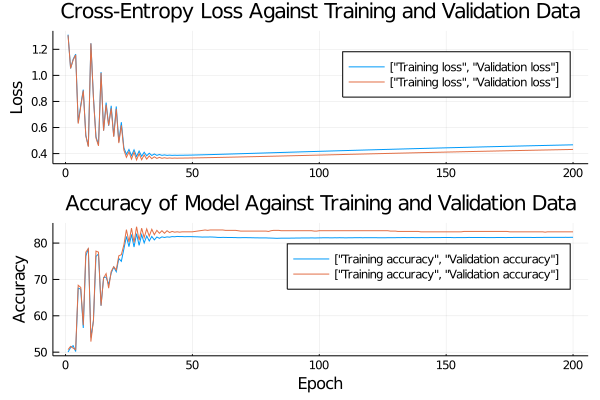

In [ ]:
p1 = plot([loss_train, loss_valid], ylab = "Loss", label=["Training loss", "Validation loss"], title = "Cross-Entropy Loss Against Training and Validation Data")
p2 = plot([acc_train, acc_valid], xlab = "Epoch", ylab = "Accuracy", label=["Training accuracy", "Validation accuracy"], title = "Accuracy of Model Against Training and Validation Data")
plot(p1, p2, layout = (2,1))

#### b: Stochastic gradient descent without momentum

SGD with no momentum pseudocode
```
for i in epochs{

    for an item of the shuffled training data{               
      - find the gradient of the parameters
    }
    
    - adjust parameters using gradient descent without momentum
    - store parameters if the accuracy is the best so far
}
```

In [ ]:
# This optimisation technique seems to require a larger amount of epochs in order to converge in loss & accuracy.
# As expected with SGD, we obtain large fluctuations in loss.
learningrate = 0.01
epochs = 500

# Initialise 2-layer MLP struct with the hidden layer having 3 neurons
# Use glorot initialisation for the weights
mlp = TwoLayerPerceptron(3)
glorot!(mlp.W1)
glorot!(mlp.w2)

# Store the loss & accuracy of the model against training & validation data
# for each epoch, to graph later.
loss_train = zeros(epochs)
acc_train  = zeros(epochs)
loss_valid = zeros(epochs)
acc_valid  = zeros(epochs)

let m = mlp
    # Keep track of the best model parameters
    bestm   = deepcopy(m)
    bestacc = 0.0

    for iteration in 1:epochs
        
        # Keep track of the model parameter gradients calculated
        gradm = zero(m)
        
        # For stochastic gradient descent:
        # Calculates the gradients at a randomly selected point
        i = rand(1:n)
        x = trainxs[i,:]
        y = trainys[i]
        fprime!(gradm, m, x, y)
        
        # adjust the parameters using gradient descent
        m.W1 .-= learningrate*gradm.W1
        m.b1 .-= learningrate*gradm.b1
        m.w2 .-= learningrate*gradm.w2
        m.b2  -= learningrate*gradm.b2
        
        # store the accuracy & loss against training & validation data for each epoch
        loss_train[iteration] = avg_loss(m, trainxs, trainys)
        acc_train[iteration]  = accuracy(m, trainxs, trainys)
        loss_valid[iteration] = avg_loss(m, devxs, devys)
        acc_valid[iteration]  = accuracy(m, devxs, devys)

        
        currentvalacc = accuracy(m, devxs, devys)
        # Here, since we have a larger number of epochs, we
        # print every 100th iteration only.
        if rem(iteration,100) == 0
            println("iteration = $iteration, accuracy = $currentvalacc")
        end
        currentvalacc > bestacc || continue
        bestm   = deepcopy(m)
        bestacc = currentvalacc
    end
    
    m.W1[:] = bestm.W1[:]
    m.b1[:] = bestm.b1[:]
    m.w2[:] = bestm.w2[:]
    m.b2 = bestm.b2
    
    m;
end;

iteration = 100, accuracy = 79.3
iteration = 200, accuracy = 81.10000000000001
iteration = 300, accuracy = 80.4
iteration = 400, accuracy = 83.89999999999999
iteration = 500, accuracy = 86.0


Below is a plot of the accuracy and loss for the above stochastic gradient descent without momentum optimisation technique, at each epoch of training, using hyperparameters: learning rate $ = 0.01$ with $500$ epochs.
As expected, the loss and accuracy of this optimisation technique fluctuates quite drastically.

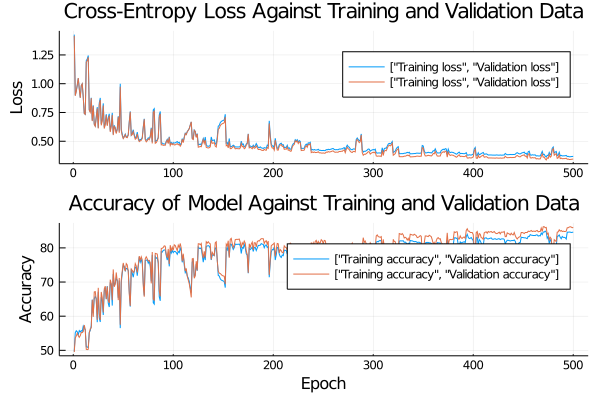

In [ ]:
p1 = plot([loss_train, loss_valid], ylab = "Loss", label=["Training loss", "Validation loss"], title = "Cross-Entropy Loss Against Training and Validation Data")
p2 = plot([acc_train, acc_valid], xlab = "Epoch", ylab = "Accuracy", label=["Training accuracy", "Validation accuracy"], title = "Accuracy of Model Against Training and Validation Data")
plot(p1, p2, layout = (2,1))

#### c: Mini-batch gradient descent without momentum

Mini-batch gradient descent with no momentum pseudocode:

```
for i in epochs{

   - Define batches using batchify function of shuffled data
   - for each batch of the batches{
              - find the gradient of the parameters using each item of the batch
              - normalise the gradients
              - adjust parameters using gradient descent without momentum
    }
    
    - store parameters if the accuracy is the best so far
}
```

In [ ]:
# batchify function,
# used to split data x into batch sizes n.
batchify(x, n) = [x[i:min(i + n - 1, length(x))] for i in 1:n:length(x)];

In [ ]:
# Dummy model parameters
learningrate = 0.02
batchsize = 256
epochs = 200

# Store the loss & accuracy of the model against training & validation data
# for each epoch, to graph later.
loss_train = zeros(epochs)
acc_train  = zeros(epochs)
loss_valid = zeros(epochs)
acc_valid  = zeros(epochs)

# Initialise 2-layer MLP struct with the hidden layer having 3 neurons
# Use glorot initialisation for the weights
mlp = TwoLayerPerceptron(3)
glorot!(mlp.W1)
glorot!(mlp.w2)

let m = mlp
    bestm   = deepcopy(m) # Keep track of the best model parameters
    bestacc = 0.0
    
    for iteration in 1:epochs
        
        # Shuffle data at each epoch
        trainingdata = shuffle(1:n)
        
        # Define mini-batches
        batches = batchify(trainingdata, batchsize)
        
        # Process and update per mini-batch
        for batch in batches
            gradm = zero(m)
            
            for i in batch
                x = trainxs[i,:]
                y = trainys[i]
                fprime!(gradm, m, x, y)
            end

            # normalise the summed gradients
            gradm.W1 ./= length(batch)
            gradm.b1 ./= length(batch)
            gradm.w2 ./= length(batch)
            gradm.b2  /= length(batch)
        
            # adjust the parameters using gradient desacent
            m.W1 .-= learningrate*gradm.W1
            m.b1 .-= learningrate*gradm.b1
            m.w2 .-= learningrate*gradm.w2
            m.b2  -= learningrate*gradm.b2
        end
        
        loss_train[iteration] = avg_loss(m, trainxs, trainys)
        acc_train[iteration]  = accuracy(m, trainxs, trainys)
        loss_valid[iteration] = avg_loss(m, devxs, devys)
        acc_valid[iteration]  = accuracy(m, devxs, devys)
        
        currentvalacc = accuracy(m, devxs, devys)
        # Here, since we have a larger number of epochs, we
        # print every 25th iteration only.
        if rem(iteration,25) == 0
            println("iteration = $iteration, accuracy = $currentvalacc")
        end
        currentvalacc > bestacc || continue
        bestm   = deepcopy(m)
        bestacc = currentvalacc
    end
    
    m.W1[:] = bestm.W1[:]
    m.b1[:] = bestm.b1[:]
    m.w2[:] = bestm.w2[:]
    m.b2 = bestm.b2
    
    m;
end;

iteration = 25, accuracy = 79.3
iteration = 50, accuracy = 82.3
iteration = 75, accuracy = 82.19999999999999
iteration = 100, accuracy = 82.19999999999999
iteration = 125, accuracy = 82.6
iteration = 150, accuracy = 82.6
iteration = 175, accuracy = 82.6
iteration = 200, accuracy = 82.89999999999999


Below is a plot of the accuracy and loss for the above mini-batch gradient descent without momentum optimisation technique, at each epoch of training, using hyperparameters: learning rate $ = 0.02$, batch size $ = 256$ with $200$ epochs.

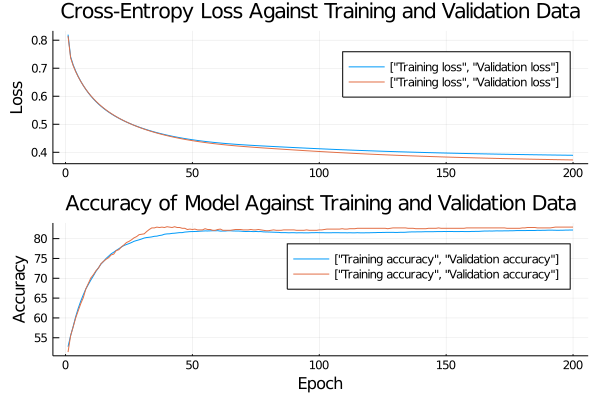

In [ ]:
p1 = plot([loss_train, loss_valid], ylab = "Loss", label=["Training loss", "Validation loss"], title = "Cross-Entropy Loss Against Training and Validation Data")
p2 = plot([acc_train, acc_valid], xlab = "Epoch", ylab = "Accuracy", label=["Training accuracy", "Validation accuracy"], title = "Accuracy of Model Against Training and Validation Data")
plot(p1, p2, layout = (2,1))

#### d: Full batch gradient descent with momentum
```
for i in epochs{
    for each item of the shuffled training data{
              - find the gradient of the parameters & sum them
    }
    
    - Scale the gradients
    - adjust parameters using gradient descent with momentum
    - calculate accuracy for this iteration
}
```

In [ ]:
# Dummy hyperparameters
learningrate        = 0.01
momentumcoefficient = 0.8
epochs              = 300

# Store the loss & accuracy of the model against training & validation data
# for each epoch, to graph later.
loss_train = zeros(epochs)
acc_train  = zeros(epochs)
loss_valid = zeros(epochs)
acc_valid  = zeros(epochs)

# Initialise 2-layer MLP struct with the hidden layer having 3 neurons
# Use glorot initialisation for the weights
mlp = TwoLayerPerceptron(5)
glorot!(mlp.W1)
glorot!(mlp.w2)

let m = mlp
    # Keep track of the best model parameters
    bestm   = deepcopy(m)
    bestacc = 0.0
    # New velocity vector introduced for gradient descent with momentum
    v = zero(m)

    for iteration in 1:epochs
        
        gradm = zero(m)
        
          # For full batch gradient descent:
          # Calculates the gradients at all data points,
          # summing up the gradients as we go.
        for i in shuffle(1:n)
            x = trainxs[i,:]
            y = trainys[i]
            fprime!(gradm, m, x, y)
        end
        
        # normalise the summed gradients
        gradm.W1 ./= n
        gradm.b1 ./= n
        gradm.w2 ./= n
        gradm.b2  /= n
        
        # adjust the parameters using gradient descent with momentum
        v.W1 = momentumcoefficient.*v.W1 - learningrate.*gradm.W1
        v.b1 = momentumcoefficient.*v.b1 - learningrate.*gradm.b1
        v.w2 = momentumcoefficient.*v.w2 - learningrate.*gradm.w2
        v.b2 = momentumcoefficient*v.b2 - learningrate*gradm.b2
        
        m.W1 .+= v.W1
        m.b1 .+= v.b1
        m.w2 .+= v.w2
        m.b2  += v.b2

        loss_train[iteration] = avg_loss(m, trainxs, trainys)
        acc_train[iteration]  = accuracy(m, trainxs, trainys)
        loss_valid[iteration] = avg_loss(m, devxs, devys)
        acc_valid[iteration]  = accuracy(m, devxs, devys)
        
        currentvalacc = accuracy(m, devxs, devys)
        # Here, since we have a larger number of epochs, we
        # print every 50th iteration only.
        if rem(iteration,50) == 0
            println("iteration = $iteration, accuracy = $currentvalacc")
        end
        currentvalacc > bestacc || continue
        bestm   = deepcopy(m)
        bestacc = currentvalacc
    end
    
    m.W1[:] = bestm.W1[:]
    m.b1[:] = bestm.b1[:]
    m.w2[:] = bestm.w2[:]
    m.b2 = bestm.b2
    
    m;
end;

iteration = 50, accuracy = 81.8
iteration = 100, accuracy = 84.2
iteration = 150, accuracy = 87.0
iteration = 200, accuracy = 88.8
iteration = 250, accuracy = 89.5
iteration = 300, accuracy = 89.7


Below is a plot of the accuracy and loss for the above stochastic gradient descent without momentum optimisation technique, at each epoch of training, using hyperparameters: learning rate $ = 0.01$, momentum coefficient $ = 0.8$ with $300$ epochs.

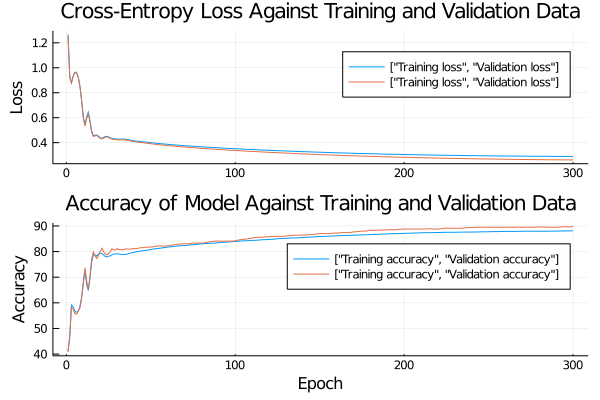

In [ ]:
p1 = plot([loss_train, loss_valid], ylab = "Loss", label=["Training loss", "Validation loss"], title = "Cross-Entropy Loss Against Training and Validation Data")
p2 = plot([acc_train, acc_valid], xlab = "Epoch", ylab = "Accuracy", label=["Training accuracy", "Validation accuracy"], title = "Accuracy of Model Against Training and Validation Data")
plot(p1, p2, layout = (2,1))

#### e: Stochastic gradient descent with momentum

```
for i in epochs{

    for an item of the shuffled training data{
              - find the gradient of the parameters
    }
    
    - adjust parameters using gradient descent with momentum
    - store parameters if the accuracy is the best so far
    end
}
```

In [ ]:
# Dummy hyperparameters
learningrate = 0.01
momentumcoefficient = 0.7
epochs = 1000

# Store the loss & accuracy of the model against training & validation data
# for each epoch, to graph later.
loss_train = zeros(epochs)
acc_train  = zeros(epochs)
loss_valid = zeros(epochs)
acc_valid  = zeros(epochs)

# Initialise 2-layer MLP struct with the hidden layer having 3 neurons
# Use glorot initialisation for the weights
mlp = TwoLayerPerceptron(3)
glorot!(mlp.W1)
glorot!(mlp.w2)

let m = mlp
    bestm   = deepcopy(m)
    bestacc = 0.0
    v = zero(m)

    for iteration in 1:epochs
        
        gradm = zero(m) # Keep track of the model parameter gradients calculated
        
        # For stochastic gradient descent:
        # Calculates the gradients at a randomly selected point,
        i = rand(1:n)
        x = trainxs[i,:]
        y = trainys[i]
        fprime!(gradm, m, x, y)
        
        v.W1 = momentumcoefficient.*v.W1 - learningrate.*gradm.W1
        v.b1 = momentumcoefficient.*v.b1 - learningrate.*gradm.b1
        v.w2 = momentumcoefficient.*v.w2 - learningrate.*gradm.w2
        v.b2 = momentumcoefficient*v.b2 - learningrate*gradm.b2
        
        m.W1 .+= v.W1
        m.b1 .+= v.b1
        m.w2 .+= v.w2
        m.b2  += v.b2
        
        loss_train[iteration] = avg_loss(m, trainxs, trainys)
        acc_train[iteration]  = accuracy(m, trainxs, trainys)
        loss_valid[iteration] = avg_loss(m, devxs, devys)
        acc_valid[iteration]  = accuracy(m, devxs, devys)
        
        currentvalacc = accuracy(m, devxs, devys)
        # Here, since we have a larger number of epochs, we
        # print every 100th iteration only.
        if rem(iteration,100) == 0
            println("iteration = $iteration, accuracy = $currentvalacc")
        end
        currentvalacc > bestacc || continue
        bestm   = deepcopy(m)
        bestacc = currentvalacc
    end
    
    m.W1[:] = bestm.W1[:]
    m.b1[:] = bestm.b1[:]
    m.w2[:] = bestm.w2[:]
    m.b2 = bestm.b2
    
    m;
end;

iteration = 100, accuracy = 84.89999999999999
iteration = 200, accuracy = 80.10000000000001
iteration = 300, accuracy = 81.0
iteration = 400, accuracy = 85.8
iteration = 500, accuracy = 86.3
iteration = 600, accuracy = 85.9
iteration = 700, accuracy = 84.3
iteration = 800, accuracy = 82.8
iteration = 900, accuracy = 81.5
iteration = 1000, accuracy = 82.69999999999999


Below is a plot of the accuracy and loss for the above stochastic gradient descent without momentum optimisation technique, at each epoch of training, using hyperparameters: learning rate $ = 0.01$, momentum coefficient $ = 0.7$ with $1,000$ epochs.

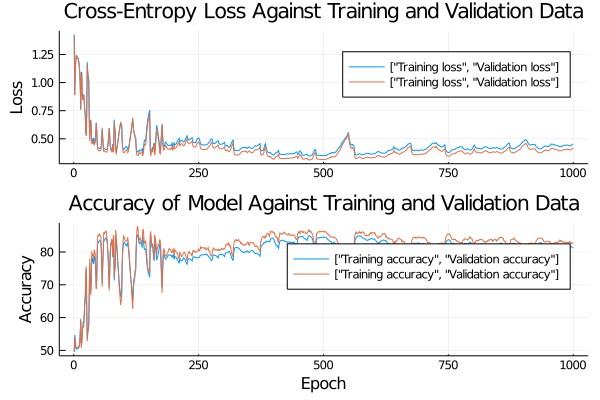

In [ ]:
p1 = plot([loss_train, loss_valid], ylab = "Loss", label=["Training loss", "Validation loss"], title = "Cross-Entropy Loss Against Training and Validation Data")
p2 = plot([acc_train, acc_valid], xlab = "Epoch", ylab = "Accuracy", label=["Training accuracy", "Validation accuracy"], title = "Accuracy of Model Against Training and Validation Data")
plot(p1, p2, layout = (2,1))

#### f: Mini-batch gradient descent with momentum
```
for i in epochs{

    - Define batches using batchify function of shuffled data

    for each batch of the batches{
              - find the gradient of the parameters using each item of the batch
              - normalise the gradients
              - adjust parameters using gradient descent with momentum
    }
    
    - store parameters if the accuracy is the best so far
}
```

In [ ]:
# Dummy hyperparameters
learningrate = 0.01
batchsize = 256
momentumcoefficient = 0.9
epochs = 250

# Store the loss & accuracy of the model against training & validation data
# for each epoch, to graph later.
loss_train = zeros(epochs)
acc_train  = zeros(epochs)
loss_valid = zeros(epochs)
acc_valid  = zeros(epochs)

# Initialise 2-layer MLP struct with the hidden layer having 3 neurons
# Use glorot initialisation for the weights
mlp = TwoLayerPerceptron(3)
glorot!(mlp.W1)
glorot!(mlp.w2)

let m = mlp
    bestm   = deepcopy(m) 
    bestacc = 0.0
    v = zero(m)
    
    for iteration in 1:epochs
        
        # Shuffle data at each epoch
        trainingdata = shuffle(1:n)
        
        # Define mini-batches
        batches = batchify(trainingdata, batchsize)
        
        # Process and update per mini-batch
        for batch in batches
            gradm = zero(m)
            
            for i in batch
                x = trainxs[i,:]
                y = trainys[i]
                fprime!(gradm, m, x, y)
            end

            # normalise the summed gradients
            gradm.W1 ./= length(batch)
            gradm.b1 ./= length(batch)
            gradm.w2 ./= length(batch)
            gradm.b2  /= length(batch)
        
            # adjust the parameters
            v.W1 = momentumcoefficient.*v.W1 - learningrate.*gradm.W1
            v.b1 = momentumcoefficient.*v.b1 - learningrate.*gradm.b1
            v.w2 = momentumcoefficient.*v.w2 - learningrate.*gradm.w2
            v.b2 = momentumcoefficient.*v.b2 - learningrate.*gradm.b2
        
            m.W1 .+= v.W1
            m.b1 .+= v.b1
            m.w2 .+= v.w2
            m.b2  += v.b2
        end
        
        loss_train[iteration] = avg_loss(m, trainxs, trainys)
        acc_train[iteration]  = accuracy(m, trainxs, trainys)
        loss_valid[iteration] = avg_loss(m, devxs, devys)
        acc_valid[iteration]  = accuracy(m, devxs, devys)
        
        currentvalacc = accuracy(m, devxs, devys)
        # Here, since we have a larger number of epochs, we
        # print every 50th iteration only.
        if rem(iteration,50) == 0
            println("iteration = $iteration, accuracy = $currentvalacc")
        end
        currentvalacc > bestacc || continue
        bestm   = deepcopy(m)
        bestacc = currentvalacc
    end
    
    m.W1[:] = bestm.W1[:]
    m.b1[:] = bestm.b1[:]
    m.w2[:] = bestm.w2[:]
    m.b2 = bestm.b2
    
    m;
end;

iteration = 50, accuracy = 84.7
iteration = 100, accuracy = 83.8
iteration = 150, accuracy = 83.6
iteration = 200, accuracy = 83.5
iteration = 250, accuracy = 83.2


Below is a plot of the accuracy and loss for the above stochastic gradient descent without momentum optimisation technique, at each epoch of training, using hyperparameters: learning rate $ = 0.01$, batch size $= 256$, momentum coefficient $ = 0.9$ with $250$ epochs.

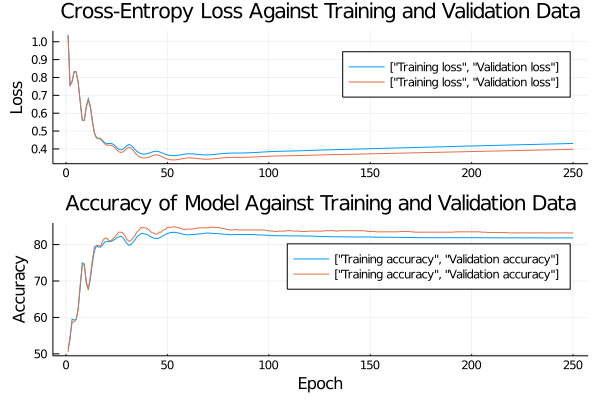

In [ ]:
p1 = plot([loss_train, loss_valid], ylab = "Loss", label=["Training loss", "Validation loss"], title = "Cross-Entropy Loss Against Training and Validation Data")
p2 = plot([acc_train, acc_valid], xlab = "Epoch", ylab = "Accuracy", label=["Training accuracy", "Validation accuracy"], title = "Accuracy of Model Against Training and Validation Data")
plot(p1, p2, layout = (2,1))

#### Attempting to find "good" values for the hyperparameters 
* Learning rate
* Batch size
* Momentum coefficient

In [ ]:
# Gradient descent function for finding optimal hyperparameters.
# This is essentially the code above for 3.4.1(f) implemented into a function grad_desc.
# To be used in grid search (cell below).

function train_MLP2(m::TwoLayerPerceptron, epochs, learningrate, batchsize, momentumcoefficient, trainxs, trainys, devxs, devys)
    # Create new struct testm to store original initialised values of weights.
    # Do this so that when using gridsearch to find best hyperparameters,
    # the random glorot initialisation of weights does not effect the test.
    testm          = deepcopy(m)
    bestm          = deepcopy(m)
    bestacc        = 0.0
    best_iter_MLP2 = 0
    train_loss     = 0.0
    train_acc      = 0.0
    val_loss       = 0.0
    
    v = zero(m)
    
    for iteration in 1:epochs
        
        # Shuffle data at each epoch
        trainingdata = shuffle(1:n)
        
        # Define mini-batches
        batches = batchify(trainingdata, batchsize)
        
        # Process and update per mini-batch
        for batch in batches
            gradm = zero(testm)
            
            for i in batch
                x = trainxs[i,:]
                y = trainys[i]
                fprime!(gradm, testm, x, y)
            end

            # normalise the summed gradients
            gradm.W1 ./= length(batch)
            gradm.b1 ./= length(batch)
            gradm.w2 ./= length(batch)
            gradm.b2  /= length(batch)
        
            # adjust the parameters
            v.W1 = momentumcoefficient.*v.W1 - learningrate.*gradm.W1
            v.b1 = momentumcoefficient.*v.b1 - learningrate.*gradm.b1
            v.w2 = momentumcoefficient.*v.w2 - learningrate.*gradm.w2
            v.b2 = momentumcoefficient.*v.b2 - learningrate.*gradm.b2
        
            testm.W1 .+= v.W1
            testm.b1 .+= v.b1
            testm.w2 .+= v.w2
            testm.b2  += v.b2
        end

        currentvalacc = accuracy(testm, devxs, devys)
        currentvalacc > bestacc || continue
        bestm          = deepcopy(testm)
        bestacc        = currentvalacc
        best_iter_MLP2 = iteration
        val_loss       = avg_loss(testm, devxs, devys)
        train_loss     = avg_loss(testm, trainxs, trainys)
        train_acc      = accuracy(testm, trainxs, trainys)
    end
    
    testm.W1[:] = bestm.W1[:]
    testm.b1[:] = bestm.b1[:]
    testm.w2[:] = bestm.w2[:]
    testm.b2 = bestm.b2
    
    return testm, train_loss, val_loss, train_acc, bestacc, best_iter_MLP2
end;

Testing hyperparameters:

* Learning rates = [0.1, 0.01, 0.05]
* Batch sizes = [32, 64, 128, 256, n = 12,000]
* Momentum coefficients = [0.95, 0.9, 0.8, 0]

In [ ]:
# Grid search for optimal hyperparameters

# Establish a “grid” based on intuitions regarding the model.
learningrates = [0.1, 0.01, 0.05]
batchsizes    = [64, 256, 512, n]
momentums     = [0.95, 0.9, 0.8, 0]

# Initialise weights here, so that when searching for optimal hyperparameters
# we're using the same initialisation for each test.
# Try a two-layer mlp model with 3 neurons in the hidden layer.
mlp = TwoLayerPerceptron(3)
glorot!(mlp.W1)
glorot!(mlp.w2)
copy_mlp = deepcopy(mlp)

optimal_acc = 0.0
optimal_learningrate = 0.0
optimal_batchsize = 0
optimal_momentum = 0.0
optimal_iteration = 0
optimal_test_acc = 0.0

# Grid search for optimal hyperparameters.
# At the moment, each model is only optimised with 100 epochs.
# Need more computing power to incorporate more & get a better validation accuracy for smaller learning rates.
# Maybe also take into account number of neurons in hidden layer as a hyperparameter?
for learningrate in learningrates
    for batchsize in batchsizes
        for momentum in momentums
            grad_desc_model = train_MLP2(mlp, 100, learningrate, batchsize, momentum, trainxs, trainys, devxs, devys)
            this_accuracy = grad_desc_model[5]
            model = grad_desc_model[1]
            println("For learning rate $learningrate, batchsize $batchsize and momentum $momentum we have best accuracy: $this_accuracy")
            this_accuracy > optimal_acc || continue
            optimal_acc          = this_accuracy
            optimal_m            = deepcopy(model)
            optimal_learningrate = learningrate
            optimal_batchsize    = batchsize
            optimal_momentum     = momentum
            optimal_iteration    = grad_desc_model[6]
            optimal_test_acc     = grad_desc_model[4]
            println("New best accuracy found! $optimal_acc%, with learning rate: $learningrate batch size: $batchsize & momentum: $momentum")
        end
    end
end

For learning rate 0.1, batchsize 64 and momentum 0.95 we have best accuracy: 89.9
New best accuracy found! 89.9%, with learning rate: 0.1 batch size: 64 & momentum: 0.95
For learning rate 0.1, batchsize 64 and momentum 0.9 we have best accuracy: 86.4
For learning rate 0.1, batchsize 64 and momentum 0.8 we have best accuracy: 86.6
For learning rate 0.1, batchsize 64 and momentum 0.0 we have best accuracy: 84.1
For learning rate 0.1, batchsize 256 and momentum 0.95 we have best accuracy: 89.9
For learning rate 0.1, batchsize 256 and momentum 0.9 we have best accuracy: 86.4
For learning rate 0.1, batchsize 256 and momentum 0.8 we have best accuracy: 86.6
For learning rate 0.1, batchsize 256 and momentum 0.0 we have best accuracy: 84.1
For learning rate 0.1, batchsize 512 and momentum 0.95 we have best accuracy: 89.9
For learning rate 0.1, batchsize 512 and momentum 0.9 we have best accuracy: 86.4
For learning rate 0.1, batchsize 512 and momentum 0.8 we have best accuracy: 86.6
For learnin

In [ ]:
# Hyperparameters
# Use "optimal" hyperparameters obtained using grid search in cell above:
@show learningrate = optimal_learningrate
@show batchsize = optimal_batchsize
@show momentumcoefficient = optimal_momentum
@show epochs = 100

loss_train = zeros(epochs)
acc_train  = zeros(epochs)
loss_valid = zeros(epochs)
acc_valid  = zeros(epochs)

let m = copy_mlp
    bestm   = deepcopy(m) 
    bestacc = 0.0
    v = zero(m)
    
    for iteration in 1:epochs
        
        # Shuffle data at each epoch
        trainingdata = shuffle(1:n)
        
        # Define mini-batches
        batches = batchify(trainingdata, batchsize)
        
        # Process and update per mini-batch
        for batch in batches
            gradm = zero(m)
            
            for i in batch
                x = trainxs[i,:]
                y = trainys[i]
                fprime!(gradm, m, x, y)
            end

            # normalise the summed gradients
            gradm.W1 ./= length(batch)
            gradm.b1 ./= length(batch)
            gradm.w2 ./= length(batch)
            gradm.b2  /= length(batch)
        
            # adjust the parameters
            v.W1 = momentumcoefficient.*v.W1 - learningrate.*gradm.W1
            v.b1 = momentumcoefficient.*v.b1 - learningrate.*gradm.b1
            v.w2 = momentumcoefficient.*v.w2 - learningrate.*gradm.w2
            v.b2 = momentumcoefficient.*v.b2 - learningrate.*gradm.b2
        
            m.W1 .+= v.W1
            m.b1 .+= v.b1
            m.w2 .+= v.w2
            m.b2  += v.b2
        end
        
        loss_train[iteration] = avg_loss(m, trainxs, trainys)
        acc_train[iteration]  = accuracy(m, trainxs, trainys)
        loss_valid[iteration] = avg_loss(m, devxs, devys)
        acc_valid[iteration]  = accuracy(m, devxs, devys)
        
        currentvalacc = accuracy(m, devxs, devys)
        # Here, since we have a larger number of epochs, we
        # print every 10th iteration only.
        if rem(iteration,10) == 0
            println("iteration = $iteration, accuracy = $currentvalacc")
        end
        currentvalacc > bestacc || continue
        bestm   = deepcopy(m)
        bestacc = currentvalacc
    end
    
    m.W1[:] = bestm.W1[:]
    m.b1[:] = bestm.b1[:]
    m.w2[:] = bestm.w2[:]
    m.b2 = bestm.b2
    
    m;
end

learningrate = optimal_learningrate = 0.1
batchsize = optimal_batchsize = 64
momentumcoefficient = optimal_momentum = 0.95
epochs = 100 = 100
iteration = 10, accuracy = 74.9
iteration = 20, accuracy = 80.0
iteration = 30, accuracy = 74.4
iteration = 40, accuracy = 85.0
iteration = 50, accuracy = 89.5
iteration = 60, accuracy = 82.5
iteration = 70, accuracy = 84.8
iteration = 80, accuracy = 87.0
iteration = 90, accuracy = 86.6
iteration = 100, accuracy = 85.1


TwoLayerPerceptron([0.125492 0.00255454 … 0.3001 0.0573289; -0.216838 -0.214418 … 0.406474 0.329001; 0.0222078 -0.236707 … -0.325034 0.033162], [-0.530159, 1.05437, -0.0425655], [2.64906, -3.48684, -0.228677], -0.2654552772336446)

Plot of the loss & accuracy on the training and validation set for each epoch of optimal hyper parameters.


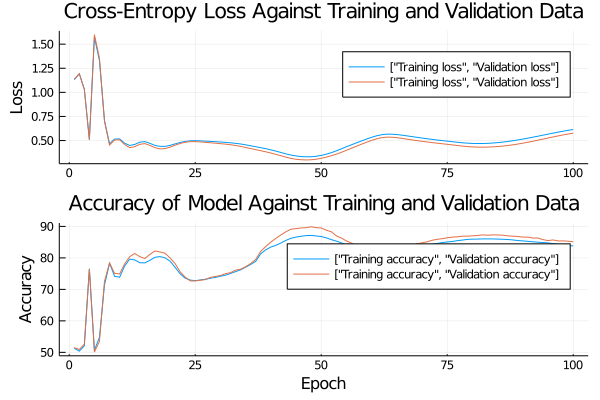

In [ ]:
p1 = plot([loss_train, loss_valid], ylab = "Loss", label=["Training loss", "Validation loss"], title = "Cross-Entropy Loss Against Training and Validation Data")
p2 = plot([acc_train, acc_valid], xlab = "Epoch", ylab = "Accuracy", label=["Training accuracy", "Validation accuracy"], title = "Accuracy of Model Against Training and Validation Data")
plot(p1, p2, layout = (2,1))